In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
#import plotly.express as px

In [2]:
# Read data
data = pd.concat((pd.read_excel('./Datos_Metagenetica.xlsx', sheet_name='El_cielo', engine='openpyxl'), pd.read_excel('./Datos_Metagenetica.xlsx', sheet_name='Chamela',engine='openpyxl')))
# replace 0 with NaN
data = data.replace(0, np.nan)
#drop columns que no se van a usar 
data = data.drop(['Database','.id', 'similarity', 'phylum_final', 
                  'class_final', 'subfamily_final', 'tribe_final',
                   'subspecies_final', 'BASE', 'OTU'], axis=1)
data

,Sequence,order_final,family_final,genus_final,species_final
0,aataaacaatataagattttggttattgcctccttcattatcactc...,Coleoptera,Mordellidae,NaN,NaN
1,aataaataatataagtttttgacttcttcctccttctttaacctta...,Coleoptera,Carabidae,Glyptolenus,NaN
2,tttaaacaatataagattttgattgttaccaccttcattaactttc...,Coleoptera,Coccinellidae,NaN,NaN
3,tataaacaatataagattctgacttcttccaccttcattaagatta...,Coleoptera,Mordellidae,NaN,NaN
4,aataaataatataagattttgactacttcctccgtcacttaccctt...,Coleoptera,Nitidulidae,NaN,NaN
...,...,...,...,...,...
1778,aataaataatataagtttttgacttttacctcctgcattaacactt...,Diptera,Tachinidae,Ischyrophaga,NaN
1779,aataaataatataagattttgattattaccaccatcaataattata...,Hymenoptera,Ichneumonidae,ichneuMalaiseNA1,NaN
1780,aataaataacataagattttgattactcccaccttctcttttttta...,Hymenoptera,Ichneumonidae,NaN,NaN
1781,aataaataatataagtttctgacttcttcccccttctttaattctt...,Lepidoptera,Erebidae,Arugisa,NaN


# Balance data

In [3]:
def balance_one_tax_data(df, col_tax_to_balance, tax_to_balance, max_samples) -> pd.DataFrame:
    '''
    df: dataframe with all data to balance
    col_tax_to_balance: column name of the tax to balance
    tax_to_balance: tax to balance
    max_samples: maximum number to save of each tax
    return: balanced dataframe
    '''
    col_index = df.columns.get_loc(col_tax_to_balance)
    if col_index + 1 < len(df.columns):
        next_tax_col = df.columns[col_index + 1]
        vc = df[df[col_tax_to_balance] == tax_to_balance][next_tax_col].value_counts()
        q25 = vc.quantile(0.25)
        selected_values = vc[vc > 4 * q25]
        balanced = pd.DataFrame(columns = df.columns)
        for i in selected_values.index:
            if vc[i] > max_samples:
                balanced = pd.concat((balanced, df[df[next_tax_col] == i].sample(max_samples)))
            else:
                balanced = pd.concat((balanced, df[df[next_tax_col] == i]))
    return balanced

print('Original data')
print(data.value_counts('family_final'))
print('Balanced data')
balance_one_tax_data(data, 'order_final', 'Diptera', 50).value_counts('family_final')

Original data
family_final
Erebidae           236
Tachinidae         200
Phoridae           162
Ichneumonidae      154
Cecidomyiidae      143
                  ... 
Phacopteronidae      1
Perilampidae         1
Derbidae             1
Disteniidae          1
f__Triozidae         1
Length: 216, dtype: int64
Balanced data


family_final
Cecidomyiidae      50
Ceratopogonidae    50
Sciaridae          50
Phoridae           50
Tachinidae         50
Sarcophagidae      33
Drosophilidae      32
Chironomidae       31
Dolichopodidae     30
Mycetophilidae     25
Muscidae           24
Syrphidae          24
Chloropidae        22
Stratiomyidae      20
Sphaeroceridae     19
Pipunculidae       15
Lauxaniidae        14
Tabanidae          14
Limoniidae         12
Psychodidae        10
dtype: int64

---
# Encoding & Concatenation

In [4]:
data['Sequence'] = data['Sequence'].apply(lambda x: x.upper())

In [5]:
def sequence_encoding(sequence):
    mapping = {"A": 0, "C": 1, "G": 2, "T": 3}
    encoded_sequence = [mapping[i] for i in sequence]
    return np.eye(4)[encoded_sequence]

In [6]:
elem0 = data['Sequence'].iloc[0]
elem1 = data['Sequence'].iloc[1]
elem0

'AATAAACAATATAAGATTTTGGTTATTGCCTCCTTCATTATCACTCCTTTTAATAAGAAGAATCGTAGAAACCGGTGCAGGTACAGGTTGAACAGTGTACCCCCCGCTGTCATCCAATATTGCCCACAGAGGTGCTTCAGTTGATTTAGCTATTTTTAGACTACATTTAGCTGGTATTTCTTCTATTTTAGGAGCAATTAATTTTATTTCTACAATAATTAATATACGACCCGCAGGAATAACCTTTGACCGAATACCCTTATTTGTCTGAGCTATTGCTATTACTGCCGTACTTCTACTATTATCTCTTCCTGTCTTAGCTGGAGCAATTACTATATTATTAACTGATCGAAATTTAAATACTACCTTTTTTGATCCCGCCGGAGGAGGAGATCCAATCTTATATCAACATCTCTTT'

In [7]:
enc0 = sequence_encoding(elem0)
enc1 = sequence_encoding(elem1)
enc0

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [8]:
enc1.shape

(418, 4)

In [9]:
def side_by_side_sequence(seq1, seq2):
    return np.concatenate((seq1, seq2), axis=1)

In [10]:
side_by_side_seq = side_by_side_sequence(enc0,enc1)
side_by_side_seq.shape
#type(syde_by_side_seq)

(418, 8)

In [11]:
side_by_side_seq

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
def deep_sequence(seq1, seq2):
    #s1 = seq1[np.newaxis, :, :]
    #s2 = seq2[np.newaxis, :, :]
    #sequence = np.concatenate((s1, s2), axis=0)
    sequence = np.dstack((seq1, seq2))
    return sequence

In [13]:
deep_seq = deep_sequence(enc0,enc1)
deep_seq.shape

(418, 4, 2)

In [14]:
deep_seq

array([[[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]]])

---
# Combinaciones

In [15]:
datos = {'Col1': ['C', 'A', 'R','M', 'E', 'N'],
        'Col2': ['S','S','M','S','M','M']}

df = pd.DataFrame(datos)
#df

In [16]:
import itertools

def combination_list(dataframe,column):
    sequences = dataframe[column].tolist()
    combinations = list(itertools.combinations(sequences, 2))
    return combinations

In [17]:
combinations = combination_list(df,'Col1')
#combinations

In [18]:
def combination_matrix(df,sequence_column,tax_column):
    combinaciones = []
    for sequence1, sequence2 in combination_list(df,sequence_column):
        z = zip(df[df[sequence_column] == sequence1][tax_column], df[df[sequence_column] == sequence2][tax_column])
        for clase1, clase2 in z:
            combinaciones.append([sequence1, sequence2, clase1, clase2])

    df_combinaciones = pd.DataFrame(combinaciones, columns=['Sequence1', 'Sequence2', 'Tax1', 'Tax2'])
    return df_combinaciones

In [19]:
nuevo_df = combination_matrix(df,'Col1','Col2')
#nuevo_df

In [20]:
def tax_comparison(dataframe, tax1, tax2):
    dataframe['Same'] = dataframe[tax1] == dataframe[tax2]
    return dataframe

In [21]:
input_matrix = tax_comparison(nuevo_df,'Tax1','Tax2')
input_matrix

,Sequence1,Sequence2,Tax1,Tax2,Same
0,C,A,S,S,True
1,C,R,S,M,False
2,C,M,S,S,True
3,C,E,S,M,False
4,C,N,S,M,False
5,A,R,S,M,False
6,A,M,S,S,True
7,A,E,S,M,False
8,A,N,S,M,False
9,R,M,M,S,False


---
# Final Matrix

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def final_matrix(data,concat_type):
    
    #Pasamos a letras mayúsculas las cadenas
    data['Sequence'] = data['Sequence'].apply(lambda x: x.upper())
    #Llamamos a la función para filtrar los datos
    balanced_data = balance_one_tax_data(data, 'order_final', 'Diptera', 50)
    #Llamamos a la función para realizar todas las combinaciones
    combinations = combination_matrix(balanced_data,'Sequence',"family_final")
    #Llamamos a la función para determinar si los Taxones son iguales
    DNA_matrix = tax_comparison(combinations,'Tax1','Tax2')
    #Pasamos los valores boolean a integer
    DNA_matrix['Same'] = DNA_matrix['Same'].astype(int)
    
    DNA_matrix['Paired_seq'] = ''  # Creamos una columna vacía para almacenar los resultados
    for index, row in DNA_matrix.iterrows():
        sequence1 = row['Sequence1']
        sequence2 = row['Sequence2']
        encoding1 = sequence_encoding(sequence1)
        encoding2 = sequence_encoding(sequence2)
        vectors_padded = pad_sequences([encoding1, encoding2], padding='post')
        paired_sequences = concat_type(vectors_padded[0], vectors_padded[0])
        DNA_matrix.at[index, 'Paired_seq'] = paired_sequences
    return DNA_matrix

2023-05-21 22:00:02.467538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
final_matrix = final_matrix(data,side_by_side_sequence)
final_matrix

,Sequence1,Sequence2,Tax1,Tax2,Same,Paired_seq
0,AATAAATAATATAAGTTTTTGACTTCTTCCTCCAGCATTAATTTTA...,AATAAATAATATAAGTTTTTGATTACTTCCTCCTGCTTTAATACTT...,Tachinidae,Tachinidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
1,AATAAATAATATAAGTTTTTGACTTCTTCCTCCAGCATTAATTTTA...,AATAAATAATATAAGCTTTTGACTTCTTCCCCCTGCACTAACATTA...,Tachinidae,Tachinidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
2,AATAAATAATATAAGTTTTTGACTTCTTCCTCCAGCATTAATTTTA...,AATAAATAATATAAGTTTTTGACTTTTACCTCCTGCATTAACACTT...,Tachinidae,Tachinidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
3,AATAAATAATATAAGTTTTTGACTTCTTCCTCCAGCATTAATTTTA...,AATAAATAATATAAGTTTTTGATTACTTCCTCCTTCAGTAACTTTA...,Tachinidae,Tachinidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
4,AATAAATAATATAAGTTTTTGACTTCTTCCTCCAGCATTAATTTTA...,AATAAATAACATAAGTTTTTGACTACTTCCACCGGCATTAACCCTT...,Tachinidae,Tachinidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...
165086,AATAAATAACCTAAGTTTTTGACTTTTACCTCCTTCTTTATTACTT...,AATAAATAATATAAGATTTTGACTTTTACCTCCTTCTTTATTATTA...,Psychodidae,Psychodidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
165087,AATAAATAACCTAAGTTTTTGACTTTTACCTCCTTCTTTATTACTT...,AATAAATAATTTAAGTTTTTGACTTTTACCTCCTTCTTTGCTTTTA...,Psychodidae,Psychodidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
165088,AATAAATAATTTAAGATTTTGATTATTACCTCCTTCTTTATTACTT...,AATAAATAATATAAGATTTTGACTTTTACCTCCTTCTTTATTATTA...,Psychodidae,Psychodidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."
165089,AATAAATAATTTAAGATTTTGATTATTACCTCCTTCTTTATTACTT...,AATAAATAATTTAAGTTTTTGACTTTTACCTCCTTCTTTGCTTTTA...,Psychodidae,Psychodidae,1,"[[1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, ..."


In [24]:
final_matrix.dtypes

Sequence1     object
Sequence2     object
Tax1          object
Tax2          object
Same           int64
Paired_seq    object
dtype: object

---
# Data preparation for CNN

In [31]:
from sklearn.model_selection import train_test_split

# Obtenemos las secuencias de ADN en una variable 'X' y las etiquetas en una variable 'y'
DNA = np.array(list(final_matrix.loc[:, 'Paired_seq'])) # dim = (31626,418,8)
labels = np.array(list(final_matrix.loc[:, 'Same'])) # dim = (31626,1)
#X

In [32]:
# Divide los datos en conjuntos de entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
DNA_train, DNA_test, labels_train, labels_test = train_test_split(
    DNA, labels, test_size=0.20, random_state=42)

print("Forma de X_train:", DNA_train.shape)
print("Forma de y_train:", labels_train.shape)

print("Forma de X_test:", DNA_test.shape)
print("Forma de y_test:", labels_test.shape)

Forma de X_train: (132072, 418, 8)
Forma de y_train: (132072,)
Forma de X_test: (33019, 418, 8)
Forma de y_test: (33019,)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import SGD

"""
CNN = Sequential([
    #Input(shape=(418, 4, 2)),

    Conv1D(filters=32, kernel_size=3, activation=relu, padding='same', input_shape=(418,4,2)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=3, activation=relu),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

CNN.summary()
"""
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation=relu, input_shape=(418, 8)))
model.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation=relu))
model.add(Conv1D(filters=32, kernel_size=1, activation=relu))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation=relu))
model.add(Dense(1, activation=sigmoid))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 416, 32)           800       
                                                                 
 conv1d_5 (Conv1D)           (None, 416, 32)           1056      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 208, 32)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 206, 64)           6208      
                                                                 
 conv1d_7 (Conv1D)           (None, 206, 32)           2080      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 103, 32)          0         
 1D)                                                  

In [34]:
# Compile: Define training parameters

epochs = 50
lrate = 0.001
decay = lrate / epochs
optim = SGD(learning_rate = lrate, momentum = 0.90, nesterov = True)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_accuracy'])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

BATCHES = final_matrix.shape[0] // 64

model.fit(DNA_train, labels_train, batch_size=BATCHES, epochs=epochs, verbose=2, validation_split=0.30, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/200
36/36 - 12s - loss: 0.2711 - binary_accuracy: 0.9404 - val_loss: 0.2305 - val_binary_accuracy: 0.9401 - 12s/epoch - 340ms/step
Epoch 2/200
36/36 - 11s - loss: 0.2265 - binary_accuracy: 0.9404 - val_loss: 0.2268 - val_binary_accuracy: 0.9401 - 11s/epoch - 295ms/step
Epoch 3/200
36/36 - 11s - loss: 0.2259 - binary_accuracy: 0.9404 - val_loss: 0.2268 - val_binary_accuracy: 0.9401 - 11s/epoch - 294ms/step
Epoch 4/200
36/36 - 11s - loss: 0.2259 - binary_accuracy: 0.9404 - val_loss: 0.2268 - val_binary_accuracy: 0.9401 - 11s/epoch - 296ms/step
Epoch 5/200
36/36 - 11s - loss: 0.2259 - binary_accuracy: 0.9404 - val_loss: 0.2268 - val_binary_accuracy: 0.9401 - 11s/epoch - 315ms/step
Epoch 6/200
36/36 - 10s - loss: 0.2259 - binary_accuracy: 0.9404 - val_loss: 0.2268 - val_binary_accuracy: 0.9401 - 10s/epoch - 292ms/step
Epoch 7/200
36/36 - 11s - loss: 0.2259 - binary_accuracy: 0.9404 - val_loss: 0.2268 - val_binary_accuracy: 0.9401 - 11s/epoch - 297ms/step
Epoch 8/200
36/36 - 11s - l

KeyboardInterrupt: 

In [36]:
model.save("S2S_model.h5")


In [40]:
# Load model back into memory, and use it for prediction
from tensorflow.keras.models import load_model
DNN = load_model("S2S_model.h5")

y_test_hat = DNN.predict(x=DNA_test)
print(y_test_hat.shape)


1032/1032 [==============================] - 4s 4ms/step
(33019, 1)


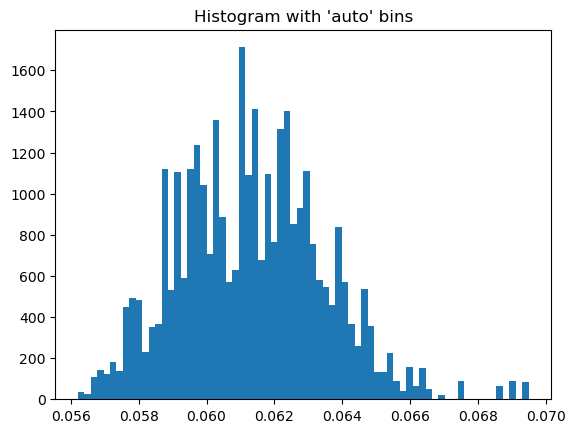

In [55]:
import matplotlib.pyplot as plt
a = np.hstack((y_test_hat))
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
